## 課題
「あるシーズンのトップ5選手とその安打数を予測する」とは…  
- 回帰タスク（安打数の予測）
- ランキングタスク（トップ5選手の決定）

## モデリング
数値的特徴（年齢、身長、AB、R、2B、3B、HRなど）とカテゴリー的特徴（Home Tm、Away Tmなど）の両方がある場合、LightGBMなどの勾配ブーストモデルが最適。  
また、十分なデータがあれば、他のツリーベースのアンサンブル手法（Random Forest、XGBoost）、あるいはディープラーニングも検討可。  

### 回帰タスクの評価
回帰指標（MAE、RMSE、R²）を使って、モデルがヒット数をどの程度予測するかを評価する。


### ランキングタスクの評価
Precision@kとRecall@kを使用する。
https://zenn.dev/yuya_sato/articles/f1a9aebe9a2e0d

## モデルの改善

トッププレーヤーモデルは、基本的に、ある選手があるシーズンに安打数でトップ5に入るかどうかを予測する二項分類モデルです。目標は、過去の実績やその他の関連要因に基づいて、来シーズンに優秀な成績を収める選手を正確に特定できるモデルを設計することです。

トッププレーヤーモデルの構築にどのようにアプローチするかは、以下の通りです：

1. データの準備  
このモデルのトレーニングデータセットは、トップ5プレーヤーとその他のプレーヤーの例をバランスよく組み合わせて構成する必要があります。例えば、トップ5の選手の例ごとに、トップ5に入らない選手の例をランダムに選択します。こうすることで、トップ5の選手とそれ以外の選手を区別することをモデルが学習するようになります。

2. 特徴の選択  
回帰モデルと同じ特徴量を使用することになりますが、トップ5プレーヤーを特に区別する特徴量を追加したり強調したりすることができます。例えば、前シーズンのランキング、キャリアベストのランキング、過去数シーズンの成績の傾向などの特徴を含めることができるかもしれません。

3. モデルの選択とトレーニング  
実際のモデルには、いくつかの選択肢があります。ロジスティック回帰、決定木、ランダムフォレスト、サポートベクターマシン、ニューラルネットワークは、すべてバイナリ分類のタスクに有効な選択肢です。数値的な特徴とカテゴリー的な特徴の両方がある場合、Random Forestのようなアンサンブル手法やgradient boosting手法（XGBoostやLightGBMなど）が有効です。

4. モデルの評価  
作成した分類モデルは、適切な評価指標を用いて評価する必要があります。Accuracy、Precision、Recall、F1 Score、Area Under the Receiver Operating Characteristics (ROC) Curve (AUC-ROC) はすべて、バイナリ分類タスクでよく使われるメトリクスです。

5. 予測と調整  
分類モデルの学習が完了したら、回帰モデルと組み合わせて使用することができます。まず、回帰モデルを使用して、各選手のヒット数を予測します。次に、分類モデルを使って、各選手が上位5位に入る可能性を予測します。これらの尤度に基づいて、最終的なランキングを調整することができます。たとえば、2人のプレーヤーの予測ヒット数がほぼ同じで、一方のプレーヤーがトップ5に入る可能性がはるかに高いと予測された場合、そのプレーヤーを上位にすることができます。

トッププレーヤー・モデルの目的は、どのプレーヤーが最も優秀である可能性が高いかという情報の追加レイヤーを組み込むことによって、回帰モデルの予測を強化することであることに留意してください。これをどのように実装するかの正確な詳細は、データとタスクの特定の要件に依存します。


1. データを準備する  
プレーヤーがそのシーズンにトップ5ヒッターであったかどうかを示すバイナリ列を作成

In [1]:
# Consider 'df' to be your DataFrame and 'hits' is the column with number of hits
# df['Top5'] = df.groupby('Year')['hits'].apply(lambda x: x >= x.nlargest(5).min()).astype(int)

2. 特徴量の選択  
回帰モデルと分類モデルの両方に同じ特徴を使う。特徴量のリストをfeature_colsと呼ぶ

In [2]:
# feature_cols = ['age', 'Years_since_debut', 'tall', ...]  # Add all relevant feature column names here.

3. モデルの選択とトレーニング

データをトレーニングセットとテストセットに分割し、モデル（この場合はランダムフォレスト分類器）をインスタンス化し、モデルをトレーニング

In [3]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# X = df[feature_cols]
# y = df['Top5']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

4. モデルの評価  
AUC-ROCを使う（二値分類モデルの全体的な性能を評価するための一般的で便利な指標）。AUC-ROCは、ランダムに選ばれた正の例（トップ5の選手）が、ランダムに選ばれた負の例（トップ5の選手ではない）よりも高いスコアを持つ確率と解釈できる。

In [4]:
# from sklearn.metrics import roc_auc_score

# y_pred = model.predict_proba(X_test)[:, 1]  # Get probability estimates of the positive class
# auc_roc = roc_auc_score(y_test, y_pred)

# print(f'Test AUC-ROC: {auc_roc}')

5. 予測と調整  
回帰モデルによるランキングを調整

In [5]:
# # Get regression model predictions (here I'm just using made up predictions)
# regression_predictions = pd.DataFrame({
#     'player': ['player1', 'player2', 'player3', ...],
#     'predicted_hits': [100, 105, 98, ...],
# })

# # Use classification model to predict top-5 probability
# players_features = df[df['player'].isin(regression_predictions['player'])][feature_cols]
# top5_probabilities = model.predict_proba(players_features)[:, 1]

# # Add top-5 probabilities to regression predictions
# regression_predictions['top5_probability'] = top5_probabilities

# # Adjust rankings based on top-5 probabilities
# regression_predictions = regression_predictions.sort_values(['top5_probability', 'predicted_hits'], ascending=False)

# 環境構築

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlb-dataset/N_league_2021.csv
/kaggle/input/mlb-dataset/N_league_2011.csv
/kaggle/input/mlb-dataset/A_league_2023.csv
/kaggle/input/mlb-dataset/A_league_2021.csv
/kaggle/input/mlb-dataset/A_league_2016.csv
/kaggle/input/mlb-dataset/N_league_2012.csv
/kaggle/input/mlb-dataset/N_league_2016.csv
/kaggle/input/mlb-dataset/A_league_2015.csv
/kaggle/input/mlb-dataset/A_league_2019.csv
/kaggle/input/mlb-dataset/A_league_2011.csv
/kaggle/input/mlb-dataset/N_league_2017.csv
/kaggle/input/mlb-dataset/A_league_2013.csv
/kaggle/input/mlb-dataset/N_league_2022.csv
/kaggle/input/mlb-dataset/A_league_2022.csv
/kaggle/input/mlb-dataset/A_league_2018.csv
/kaggle/input/mlb-dataset/A_league_2020.csv
/kaggle/input/mlb-dataset/A_league_2017.csv
/kaggle/input/mlb-dataset/N_league_2020.csv
/kaggle/input/mlb-dataset/A_league_2014.csv
/kaggle/input/mlb-dataset/N_league_2014.csv
/kaggle/input/mlb-dataset/N_league_2015.csv
/kaggle/input/mlb-dataset/N_league_2013.csv
/kaggle/input/mlb-dataset/N_leag

In [7]:
import calendar
import warnings
from datetime import datetime

# import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

# データの読み込み

In [8]:
american_data = {}
national_data = {}

for year in range(2015, 2024):
    if year != 2020:
        path = f"/kaggle/input/mlb-dataset/A_league_{year}.csv"
        adf = pd.read_csv(path, encoding="Shift-JIS")
        adf.rename(columns={'順位': 'Rank', '選手名': 'Name'}, inplace=True)
        adf["Year"] = year
        adf["age"] = adf["age"] - (2023 - adf["Year"])
        adf['debut_year'] = pd.to_datetime(adf['debut_year'])
        adf['Years_since_debut'] = adf['Year'] - adf['debut_year'].dt.year
        american_data[year] = adf

        path = f"/kaggle/input/mlb-dataset/N_league_{year}.csv"
        ndf = pd.read_csv(path, encoding="Shift-JIS")
        ndf.rename(columns={'順位': 'Rank', '選手名': 'Name'}, inplace=True)
        ndf["Year"] = year
        ndf["age"] = ndf["age"] - (2023 - ndf["Year"])
        ndf['debut_year'] = pd.to_datetime(ndf['debut_year'])
        ndf['Years_since_debut'] = ndf['Year'] - ndf['debut_year'].dt.year
        national_data[year] = ndf

以下のようにリーグと年度を指定すると、スクレイピングしたcsvがdataframeとして出力されます。

In [9]:
national_data[2023]

,Rank,Name,age,debut_year,tall,weight,pro_year,position,bt,Date,Home Tm,Away Tm,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS,SS,HP2F,Year,Years_since_debut
0,1,Luis Arraez,26,2019-05-18,177.80,79.380,0,2B,L/R,2023-03-30,Miami Marlins,New York Mets,4,4,1,2,1,0,0,1,0,1,0,0,0,0.500,0.500,0.750,1.250,26.2,4.53,2023,4
1,1,Luis Arraez,26,2019-05-18,177.80,79.380,0,2B,L/R,2023-03-31,Miami Marlins,New York Mets,4,3,0,1,0,0,0,0,1,0,0,0,0,0.429,0.500,0.571,1.071,26.2,4.53,2023,4
2,1,Luis Arraez,26,2019-05-18,177.80,79.380,0,2B,L/R,2023-04-01,Miami Marlins,New York Mets,5,5,0,4,0,0,0,0,0,0,0,0,0,0.583,0.615,0.667,1.282,26.2,4.53,2023,4
3,1,Luis Arraez,26,2019-05-18,177.80,79.380,0,2B,L/R,2023-04-02,Miami Marlins,New York Mets,4,4,1,2,0,0,0,0,0,0,0,0,0,0.563,0.588,0.625,1.213,26.2,4.53,2023,4
4,1,Luis Arraez,26,2019-05-18,177.80,79.380,0,2B,L/R,2023-04-03,Miami Marlins,Minnesota Twins,5,5,0,2,0,0,0,1,0,0,0,0,0,0.524,0.545,0.571,1.116,26.2,4.53,2023,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6446,100,Jack Suwinski,24,2022-04-26,187.96,97.524,2016,CF,L/L,2023-06-16,Milwaukee Brewers,Pittsburgh Pirates,4,2,1,0,0,0,0,0,1,1,0,0,1,0.240,0.360,0.530,0.890,28.6,4.29,2023,1
6447,100,Jack Suwinski,24,2022-04-26,187.96,97.524,2016,CF,L/L,2023-06-17,Milwaukee Brewers,Pittsburgh Pirates,1,1,0,0,0,0,0,0,0,1,0,0,0,0.239,0.359,0.527,0.886,28.6,4.29,2023,1
6448,100,Jack Suwinski,24,2022-04-26,187.96,97.524,2016,CF,L/L,2023-06-18,Milwaukee Brewers,Pittsburgh Pirates,4,4,0,0,0,0,0,0,0,1,0,0,0,0.234,0.352,0.516,0.868,28.6,4.29,2023,1
6449,100,Jack Suwinski,24,2022-04-26,187.96,97.524,2016,CF,L/L,2023-06-19,Pittsburgh Pirates,Chicago Cubs,1,1,0,0,0,0,0,0,0,1,0,0,0,0.233,0.351,0.513,0.864,28.6,4.29,2023,1


In [10]:
def zero_missing_percent(data, miss_col):
    miss_num = american_data[2016][american_data[2016][miss_col]==0].shape[0]
    miss_pct = round(miss_num/american_data[2016].shape[0],4)
    print(f"{miss_col}: ゼロ欠損値{miss_num}個、欠損値率{miss_pct}")

zero_missing_percent(american_data[2016], 'pro_year')
print(sorted(american_data[2016]['pro_year'].unique()))

pro_year: ゼロ欠損値4789個、欠損値率0.3418
[0, 1995, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]


* ゼロ欠損値が多いのでpro_yearは使わない
* debut_yearは、プロとしての経験年数であるYears_since_debutに変換
* weightは毎年変わるので使わない
* positionは変わる可能性があるので使わない

# 関数の作成

選手ごとに各年度の最終成績を計算する関数です。

In [11]:
def calculate_stats(league_data):
    all_years_df = pd.concat(league_data.values())
    stats = all_years_df.groupby(['Year', 'Name']).agg({
        'age': 'first',
        'Years_since_debut': 'first',
        'tall': 'first',
        'bt': 'first',
        'Date': 'first',
        'Home Tm': 'first',
        'Away Tm': 'first',
        'Rank': 'first',
        'SS': 'first',
        'HP2F': 'first',
        'PA': 'sum',
        'AB': 'sum',
        'R': 'sum',
        'H': 'sum',
        '2B': 'sum',
        '3B': 'sum',
        'HR': 'sum',
        'RBI': 'sum',
        'BB': 'sum',
        'SO': 'sum',
        'SB': 'sum',
        'CS': 'sum',
        'HBP': 'sum'
    })

    stats['AVG'] = stats['H'] / stats['AB']
    stats['OBP'] = (stats['H'] + stats['BB'] + stats['HBP']) / stats['PA']
    stats['SLG'] = (stats['H'] + 2*stats['2B'] + 3*stats['3B'] + 4*stats['HR']) / stats['AB']
    stats['OPS'] = stats['OBP'] + stats['SLG']
    stats = stats.sort_values(by=['Year', 'H'], ascending=[True, False])

    return stats.reset_index()


選手ごとに60試合経過時点での成績を計算する関数です。

In [12]:
def calculate_stats_first_70_games(league_data):
    all_years_df = pd.concat(league_data.values())
    all_years_df['Date'] = pd.to_datetime(all_years_df['Date'])
    first_70_games = all_years_df.sort_values('Date').groupby(['Year', 'Name']).apply(lambda x: x.head(70)).reset_index(drop=True)
    stats = first_70_games.groupby(['Year', 'Name']).agg({
        'age': 'first',
        'Years_since_debut': 'first',
        'tall': 'first',
        'bt': 'first',
        'Date': 'first',
        'Home Tm': 'first',
        'Away Tm': 'first',
        'Rank': 'first',
        'SS': 'first',
        'HP2F': 'first',
        'PA': 'sum',
        'AB': 'sum',
        'R': 'sum',
        'H': 'sum',
        '2B': 'sum',
        '3B': 'sum',
        'HR': 'sum',
        'RBI': 'sum',
        'BB': 'sum',
        'SO': 'sum',
        'SB': 'sum',
        'CS': 'sum',
        'HBP': 'sum'
    })
    
    stats['AVG'] = stats['H'] / stats['AB']
    stats['OBP'] = (stats['H'] + stats['BB'] + stats['HBP']) / stats['PA']
    stats['SLG'] = (stats['H'] + 2*stats['2B'] + 3*stats['3B'] + 4*stats['HR']) / stats['AB']
    stats['OPS'] = stats['OBP'] + stats['SLG']
    stats = stats.sort_values(by=['Year', 'H'], ascending=[True, False])
    
    return stats.reset_index()


# 最終成績

作った関数を使って結果を表示します。

In [13]:
american_yearly_totals_df = calculate_stats(american_data)
national_yearly_totals_df = calculate_stats(national_data)

american_yearly_totals_df_first_70 = calculate_stats_first_70_games(american_data)
national_yearly_totals_df_first_70 = calculate_stats_first_70_games(national_data)

categorical_cols = ['bt', 'Home Tm', 'Away Tm']

for col in categorical_cols:
    american_yearly_totals_df[col] = american_yearly_totals_df[col].astype('category')
    national_yearly_totals_df[col] = national_yearly_totals_df[col].astype('category')
    american_yearly_totals_df_first_70[col] = american_yearly_totals_df_first_70[col].astype('category')
    national_yearly_totals_df_first_70[col] = national_yearly_totals_df_first_70[col].astype('category')

アメリカンリーグの各選手の最終成績を各年度100人ずつ、2011~2023年分(２０２０年度を除く)を全て繋げたdataframeはこのようになります。

In [14]:
american_yearly_totals_df

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Jose Altuve,25,4,167.64,R/R,2015-04-06,Houston Astros,Cleveland Indians,1,28.5,4.11,689,638,86,200,40,4,15,66,33,67,38,13,9,0.313480,0.351234,0.551724,0.902958
1,2015,Xander Bogaerts,22,2,187.96,R/R,2015-04-06,Philadelphia Phillies,Boston Red Sox,2,28.3,4.24,654,613,84,196,35,3,7,81,32,101,10,2,3,0.319739,0.353211,0.494290,0.847501
2,2015,Prince Fielder,31,10,180.34,L/R,2015-04-06,Oakland Athletics,Texas Rangers,3,24.8,4.78,693,613,78,187,28,0,23,98,64,88,0,0,11,0.305057,0.378066,0.546493,0.924559
3,2015,Ian Kinsler,32,9,182.88,R/R,2015-04-06,Detroit Tigers,Minnesota Twins,4,26.9,4.51,675,624,94,185,35,7,11,73,43,80,10,6,3,0.296474,0.342222,0.512821,0.855043
4,2015,Josh Donaldson,29,5,185.42,R/R,2015-04-06,New York Yankees,Toronto Blue Jays,5,26.6,4.51,711,620,122,184,41,2,41,123,73,133,6,0,6,0.296774,0.369902,0.703226,1.073127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,2023,Zach Neto,22,0,182.88,R/R,2023-04-15,Boston Red Sox,Los Angeles Angels,95,27.8,4.43,199,174,24,45,12,0,6,22,11,37,5,0,11,0.258621,0.336683,0.534483,0.871166
795,2023,Triston Casas,23,1,195.58,L/R,2023-03-30,Boston Red Sox,Baltimore Orioles,97,24.5,4.73,244,205,29,44,10,1,8,24,37,63,0,0,0,0.214634,0.331967,0.482927,0.814894
796,2023,Jake Burger,27,2,187.96,R/R,2023-04-06,Chicago White Sox,San Francisco Giants,98,28.2,4.39,199,183,27,43,10,1,16,36,10,67,1,1,4,0.234973,0.286432,0.710383,0.996815
797,2023,Ramon Laureano,28,5,180.34,R/R,2023-03-30,Oakland Athletics,Los Angeles Angels,99,27.5,4.49,215,198,21,43,9,3,5,17,13,65,8,0,4,0.217172,0.279070,0.454545,0.733615


ナショナルリーグの各選手の最終成績を各年度100人ずつ、2011~2023年分(２０２０年度を除く)を全て繋げたdataframeはこのようになります。

In [15]:
national_yearly_totals_df

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Dee Strange-Gordon,27,4,180.34,L/R,2015-04-06,Miami Marlins,Atlanta Braves,1,29.0,3.98,653,615,88,205,24,8,4,46,25,91,58,20,2,0.333333,0.355283,0.476423,0.831706
1,2015,AJ Pollock,27,3,185.42,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,2,29.0,4.30,673,609,111,192,39,6,20,76,53,89,39,7,2,0.315271,0.367013,0.604269,0.971283
2,2015,Paul Goldschmidt,27,4,190.50,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,3,27.4,4.50,695,567,103,182,38,2,33,110,118,151,21,5,2,0.320988,0.434532,0.698413,1.132945
3,2015,Ben Revere,27,5,175.26,L/R,2015-04-06,Philadelphia Phillies,Boston Red Sox,78,28.4,4.21,634,592,84,181,22,7,2,45,32,64,31,7,2,0.305743,0.339117,0.429054,0.768171
4,2015,Nick Markakis,31,9,185.42,L/L,2015-04-06,Miami Marlins,Atlanta Braves,4,25.4,4.66,686,612,73,181,38,1,3,53,70,83,2,1,3,0.295752,0.370262,0.444444,0.814707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2023,Randal Grichuk,31,9,187.96,R/R,2023-04-29,Colorado Rockies,Arizona Diamondbacks,94,27.0,4.63,172,154,24,45,14,1,1,15,14,35,1,2,3,0.292208,0.360465,0.519481,0.879946
796,2023,Yuli Gurriel,39,7,182.88,R/R,2023-03-31,Miami Marlins,New York Mets,95,26.5,4.60,190,173,18,45,7,3,3,14,14,22,4,0,1,0.260116,0.315789,0.462428,0.778217
797,2023,Jack Suwinski,24,1,187.96,L/L,2023-03-30,Cincinnati Reds,Pittsburgh Pirates,100,28.6,4.29,232,193,30,44,8,0,15,35,34,74,6,1,2,0.227979,0.344828,0.621762,0.966589
798,2023,Trent Grisham,26,4,180.34,L/L,2023-03-30,San Diego Padres,Colorado Rockies,98,27.8,4.46,259,223,28,44,17,0,6,17,34,74,5,3,1,0.197309,0.305019,0.457399,0.762418


In [16]:
filtered_df = national_yearly_totals_df[(national_yearly_totals_df['Year'] == 2023) & (national_yearly_totals_df['Name'] == 'Luis Arraez')]
filtered_df

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
700,2023,Luis Arraez,26,4,177.8,L/R,2023-03-30,Miami Marlins,New York Mets,1,26.2,4.53,286,259,31,103,15,1,2,35,21,15,1,2,4,0.397683,0.447552,0.555985,1.003537


# 70試合経過時点での成績

アメリカンリーグの各選手の６０試合経過時点での成績を各年度100人ずつ、2011~2023年分(２０２０年度を除く)を全て繋げたdataframeはこのようになります。

In [17]:
american_yearly_totals_df_first_70

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Jason Kipnis,28,4,180.34,L/R,2015-04-06,Houston Astros,Cleveland Indians,15,27.3,4.38,327,280,49,99,24,4,5,31,35,42,10,5,6,0.353571,0.428135,0.639286,1.067420
1,2015,Prince Fielder,31,10,180.34,L/R,2015-04-06,Oakland Athletics,Texas Rangers,3,24.8,4.78,308,272,35,93,16,0,11,47,27,37,0,0,7,0.341912,0.412338,0.621324,1.033661
2,2015,Billy Burns,25,1,175.26,S/R,2015-05-02,Texas Rangers,Oakland Athletics,30,29.1,3.99,317,299,42,92,12,5,2,18,13,43,20,4,4,0.307692,0.343849,0.464883,0.808732
3,2015,Miguel Cabrera,32,12,193.04,R/R,2015-04-06,Detroit Tigers,Minnesota Twins,41,24.0,5.04,301,251,42,88,13,1,15,52,47,50,1,1,2,0.350598,0.455150,0.705179,1.160329
4,2015,Dustin Pedroia,31,9,175.26,R/R,2015-04-06,Philadelphia Phillies,Boston Red Sox,77,27.0,4.38,318,285,34,86,14,0,9,33,27,38,1,1,2,0.301754,0.361635,0.526316,0.887951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,2023,Zach Neto,22,0,182.88,R/R,2023-04-15,Boston Red Sox,Los Angeles Angels,95,27.8,4.43,199,174,24,45,12,0,6,22,11,37,5,0,11,0.258621,0.336683,0.534483,0.871166
795,2023,Triston Casas,23,1,195.58,L/R,2023-03-30,Boston Red Sox,Baltimore Orioles,97,24.5,4.73,244,205,29,44,10,1,8,24,37,63,0,0,0,0.214634,0.331967,0.482927,0.814894
796,2023,Jake Burger,27,2,187.96,R/R,2023-04-06,Chicago White Sox,San Francisco Giants,98,28.2,4.39,199,183,27,43,10,1,16,36,10,67,1,1,4,0.234973,0.286432,0.710383,0.996815
797,2023,Ramon Laureano,28,5,180.34,R/R,2023-03-30,Oakland Athletics,Los Angeles Angels,99,27.5,4.49,215,198,21,43,9,3,5,17,13,65,8,0,4,0.217172,0.279070,0.454545,0.733615


ナショナルリーグの各選手の６０試合経過時点での成績を各年度100人ずつ、2011~2023年分(２０２０年度を除く)を全て繋げたdataframeはこのようになります。

In [18]:
national_yearly_totals_df_first_70

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Dee Strange-Gordon,27,4,180.34,L/R,2015-04-06,Miami Marlins,Atlanta Braves,1,29.0,3.98,319,305,38,107,15,3,0,17,10,49,25,9,1,0.350820,0.369906,0.478689,0.848594
1,2015,Paul Goldschmidt,27,4,190.50,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,3,27.4,4.50,308,251,51,89,15,1,19,57,56,57,12,4,0,0.354582,0.470779,0.788845,1.259624
2,2015,Yunel Escobar,32,8,187.96,R/R,2015-04-06,Washington Nationals,New York Mets,13,25.6,4.65,296,271,38,87,10,1,4,27,18,39,1,2,5,0.321033,0.371622,0.464945,0.836566
3,2015,Norichika Aoki,33,3,175.26,L/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,87,26.7,4.10,301,272,33,84,8,2,2,19,23,17,12,5,5,0.308824,0.372093,0.419118,0.791211
4,2015,AJ Pollock,27,3,185.42,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,2,29.0,4.30,296,273,46,83,14,2,9,34,18,51,14,5,1,0.304029,0.344595,0.560440,0.905034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2023,Yuli Gurriel,39,7,182.88,R/R,2023-03-31,Miami Marlins,New York Mets,95,26.5,4.60,190,173,18,45,7,3,3,14,14,22,4,0,1,0.260116,0.315789,0.462428,0.778217
796,2023,Jack Suwinski,24,1,187.96,L/L,2023-03-30,Cincinnati Reds,Pittsburgh Pirates,100,28.6,4.29,232,193,30,44,8,0,15,35,34,74,6,1,2,0.227979,0.344828,0.621762,0.966589
797,2023,Kyle Schwarber,30,8,182.88,L/R,2023-03-30,Texas Rangers,Philadelphia Phillies,78,24.6,4.67,303,248,42,44,7,1,19,38,52,86,0,1,3,0.177419,0.326733,0.552419,0.879152
798,2023,Trent Grisham,26,4,180.34,L/L,2023-03-30,San Diego Padres,Colorado Rockies,98,27.8,4.46,259,223,28,44,17,0,6,17,34,74,5,3,1,0.197309,0.305019,0.457399,0.762418


# 閾値
規定打席を使う

In [19]:
american_yearly_totals_df_first_70 = american_yearly_totals_df_first_70[american_yearly_totals_df_first_70['PA'] >= 217].reset_index(drop=True)
national_yearly_totals_df_first_70 = national_yearly_totals_df_first_70[national_yearly_totals_df_first_70['PA'] >= 217].reset_index(drop=True)

american_yearly_totals_df.drop_duplicates(subset=['Name', 'Year'], keep='first', inplace=True)
national_yearly_totals_df.drop_duplicates(subset=['Name', 'Year'], keep='first', inplace=True)

regular_players = american_yearly_totals_df_first_70[['Name', 'Year']]
american_yearly_totals_df = pd.merge(american_yearly_totals_df, regular_players, on=['Name', 'Year']).reset_index(drop=True)

regular_players = national_yearly_totals_df_first_70[['Name', 'Year']]
national_yearly_totals_df = pd.merge(national_yearly_totals_df, regular_players, on=['Name', 'Year']).reset_index(drop=True)

In [20]:
# Apply the filter for data prior to 2023
american_yearly_totals_df_before_2023 = american_yearly_totals_df[(american_yearly_totals_df['Year'] < 2023) & (american_yearly_totals_df['H'] >= 75)]
national_yearly_totals_df_before_2023 = national_yearly_totals_df[(national_yearly_totals_df['Year'] < 2023) & (national_yearly_totals_df['H'] >= 75)]
# Get the data for 2023
american_yearly_totals_df_2023 = american_yearly_totals_df[american_yearly_totals_df['Year'] == 2023]
national_yearly_totals_df_2023 = national_yearly_totals_df[national_yearly_totals_df['Year'] == 2023]
# Concatenate the data
american_yearly_totals_df = pd.concat([american_yearly_totals_df_before_2023, american_yearly_totals_df_2023], ignore_index=True)
national_yearly_totals_df = pd.concat([national_yearly_totals_df_before_2023, national_yearly_totals_df_2023], ignore_index=True)

american_yearly_totals_df_first_70.drop_duplicates(subset=['Name', 'Year'], keep='first', inplace=True)
national_yearly_totals_df_first_70.drop_duplicates(subset=['Name', 'Year'], keep='first', inplace=True)
regular_players = american_yearly_totals_df[['Name', 'Year']]
american_yearly_totals_df_first_70 = pd.merge(american_yearly_totals_df_first_70, regular_players, on=['Name', 'Year']).reset_index(drop=True)
regular_players = national_yearly_totals_df[['Name', 'Year']]
national_yearly_totals_df_first_70 = pd.merge(national_yearly_totals_df_first_70, regular_players, on=['Name', 'Year']).reset_index(drop=True)

In [21]:
national_yearly_totals_df

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Dee Strange-Gordon,27,4,180.34,L/R,2015-04-06,Miami Marlins,Atlanta Braves,1,29.0,3.98,653,615,88,205,24,8,4,46,25,91,58,20,2,0.333333,0.355283,0.476423,0.831706
1,2015,AJ Pollock,27,3,185.42,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,2,29.0,4.30,673,609,111,192,39,6,20,76,53,89,39,7,2,0.315271,0.367013,0.604269,0.971283
2,2015,Paul Goldschmidt,27,4,190.50,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,3,27.4,4.50,695,567,103,182,38,2,33,110,118,151,21,5,2,0.320988,0.434532,0.698413,1.132945
3,2015,Ben Revere,27,5,175.26,L/R,2015-04-06,Philadelphia Phillies,Boston Red Sox,78,28.4,4.21,634,592,84,181,22,7,2,45,32,64,31,7,2,0.305743,0.339117,0.429054,0.768171
4,2015,Nick Markakis,31,9,185.42,L/L,2015-04-06,Miami Marlins,Atlanta Braves,4,25.4,4.66,686,612,73,181,38,1,3,53,70,83,2,1,3,0.295752,0.370262,0.444444,0.814707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,2023,Alex Call,28,1,180.34,R/R,2023-03-30,Washington Nationals,Atlanta Braves,90,28.8,4.28,251,220,24,46,9,0,3,20,26,48,6,2,3,0.209091,0.298805,0.345455,0.644259
747,2023,Joey Wiemer,24,0,193.04,R/R,2023-04-01,Chicago Cubs,Milwaukee Brewers,92,28.9,4.24,240,218,29,46,12,0,10,26,21,73,10,1,0,0.211009,0.279167,0.504587,0.783754
748,2023,Miguel Vargas,23,1,190.50,R/R,2023-03-30,Los Angeles Dodgers,Arizona Diamondbacks,91,27.8,4.33,260,220,31,46,14,3,6,29,33,50,3,2,2,0.209091,0.311538,0.486364,0.797902
749,2023,Jack Suwinski,24,1,187.96,L/L,2023-03-30,Cincinnati Reds,Pittsburgh Pirates,100,28.6,4.29,232,193,30,44,8,0,15,35,34,74,6,1,2,0.227979,0.344828,0.621762,0.966589


In [22]:
national_yearly_totals_df_first_70

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Dee Strange-Gordon,27,4,180.34,L/R,2015-04-06,Miami Marlins,Atlanta Braves,1,29.0,3.98,319,305,38,107,15,3,0,17,10,49,25,9,1,0.350820,0.369906,0.478689,0.848594
1,2015,Paul Goldschmidt,27,4,190.50,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,3,27.4,4.50,308,251,51,89,15,1,19,57,56,57,12,4,0,0.354582,0.470779,0.788845,1.259624
2,2015,Yunel Escobar,32,8,187.96,R/R,2015-04-06,Washington Nationals,New York Mets,13,25.6,4.65,296,271,38,87,10,1,4,27,18,39,1,2,5,0.321033,0.371622,0.464945,0.836566
3,2015,Norichika Aoki,33,3,175.26,L/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,87,26.7,4.10,301,272,33,84,8,2,2,19,23,17,12,5,5,0.308824,0.372093,0.419118,0.791211
4,2015,AJ Pollock,27,3,185.42,R/R,2015-04-06,Arizona Diamondbacks,San Francisco Giants,2,29.0,4.30,296,273,46,83,14,2,9,34,18,51,14,5,1,0.304029,0.344595,0.560440,0.905034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,2023,Miguel Vargas,23,1,190.50,R/R,2023-03-30,Los Angeles Dodgers,Arizona Diamondbacks,91,27.8,4.33,260,220,31,46,14,3,6,29,33,50,3,2,2,0.209091,0.311538,0.486364,0.797902
747,2023,Joey Wiemer,24,0,193.04,R/R,2023-04-01,Chicago Cubs,Milwaukee Brewers,92,28.9,4.24,237,215,28,45,12,0,10,26,21,71,10,1,0,0.209302,0.278481,0.506977,0.785458
748,2023,Jack Suwinski,24,1,187.96,L/L,2023-03-30,Cincinnati Reds,Pittsburgh Pirates,100,28.6,4.29,232,193,30,44,8,0,15,35,34,74,6,1,2,0.227979,0.344828,0.621762,0.966589
749,2023,Kyle Schwarber,30,8,182.88,L/R,2023-03-30,Texas Rangers,Philadelphia Phillies,78,24.6,4.67,303,248,42,44,7,1,19,38,52,86,0,1,3,0.177419,0.326733,0.552419,0.879152


# 2022年の予測と実際の成績(アメリカンリーグ、線形回帰)
2011~2021年(2020年度を除く)の各年度70試合経過時点でのデータを使って学習し、2022年度末のヒット数を選手ごとに予測します。

In [23]:
test_data = american_yearly_totals_df[american_yearly_totals_df['Year'] == 2022]
test_data_first_70 = american_yearly_totals_df_first_70[american_yearly_totals_df_first_70['Year'] == 2022]

train_data = american_yearly_totals_df[american_yearly_totals_df['Year'] < 2022]
train_data_first_70 = american_yearly_totals_df_first_70[american_yearly_totals_df_first_70['Year'] < 2022]

train_data = pd.merge(train_data[['Year', 'Name','H']], train_data_first_70, on=['Year', 'Name'])
test_data = pd.merge(test_data[['Year', 'Name','H']], test_data_first_70, on=['Year', 'Name'])
# train_data = train_data.sort_values(by=['Year', 'H']).reset_index(drop=True)
# train_data_first_70 = train_data[['Year', 'Name']].merge(train_data_first_70, on=['Year', 'Name'], how='left')

X_train = train_data_first_70[['PA','R','2B','3B','HR','BB','SO','SB','CS']].values
# X_train = train_data_first_70[['PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']].values
y_train = train_data['H_x'].values
model = LinearRegression()
model.fit(X_train, y_train)

X_test = test_data_first_70[['PA','R','2B','3B','HR','BB','SO','SB','CS']].values
# X_test = test_data_first_70[['PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']].values
y_test = test_data['H_x'].values
y_pred = model.predict(X_test)

results_2022 = test_data[['Year', 'Name']].copy()
results_2022['Predicted_Hits'] = y_pred
results_2022['Actual_Hits'] = y_test
results_2022['Rank'] = results_2022['Actual_Hits'].rank(method='min', ascending=False)
results_2022['Rank'] = results_2022['Rank'].astype(int)

results_2022 = results_2022.sort_values(by='Predicted_Hits', ascending=False)
results_2022 = results_2022.reset_index(drop=True)
results_2022.head(20)

,Year,Name,Predicted_Hits,Actual_Hits,Rank
0,2022,Bo Bichette,182.875052,189,1
1,2022,Alex Verdugo,176.918403,166,11
2,2022,Jose Abreu,172.065384,183,2
3,2022,Vladimir Guerrero Jr.,164.295175,175,6
4,2022,Luis Arraez,162.420544,173,7
5,2022,Anthony Santander,158.186033,138,33
6,2022,Cedric Mullins,157.507610,157,16
7,2022,Bobby Witt Jr.,156.857790,150,21
8,2022,Whit Merrifield,155.738026,126,49
9,2022,Ryan Mountcastle,155.722737,139,31


In [24]:
train_data

,Year,Name,H_x,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H_y,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Jose Altuve,200,25,4,167.64,R/R,2015-04-06,Houston Astros,Cleveland Indians,1,28.5,4.11,305,281,35,82,14,0,6,30,18,30,21,7,1,0.291815,0.331148,0.476868,0.808016
1,2015,Xander Bogaerts,196,22,2,187.96,R/R,2015-04-06,Philadelphia Phillies,Boston Red Sox,2,28.3,4.24,269,252,30,74,14,3,3,31,13,38,4,1,1,0.293651,0.327138,0.488095,0.815233
2,2015,Prince Fielder,187,31,10,180.34,L/R,2015-04-06,Oakland Athletics,Texas Rangers,3,24.8,4.78,308,272,35,93,16,0,11,47,27,37,0,0,7,0.341912,0.412338,0.621324,1.033661
3,2015,Ian Kinsler,185,32,9,182.88,R/R,2015-04-06,Detroit Tigers,Minnesota Twins,4,26.9,4.51,308,274,42,72,15,2,1,27,32,42,6,2,0,0.262774,0.337662,0.408759,0.746421
4,2015,Josh Donaldson,184,29,5,185.42,R/R,2015-04-06,New York Yankees,Toronto Blue Jays,5,26.6,4.51,310,277,55,84,17,0,17,46,25,57,3,0,3,0.303249,0.361290,0.671480,1.032770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2021,Ramon Laureano,84,26,3,180.34,R/R,2021-04-01,Oakland Athletics,Houston Astros,95,27.6,4.38,303,269,39,66,13,2,13,31,25,75,11,3,8,0.245353,0.326733,0.557621,0.884353
581,2021,Eric Haase,81,28,3,177.80,R/R,2021-05-13,Detroit Tigers,Kansas City Royals,98,27.9,4.50,273,252,40,60,10,1,19,49,18,87,2,0,2,0.238095,0.293040,0.630952,0.923993
582,2021,Wander Franco,81,20,0,177.80,S/R,2021-06-22,Tampa Bay Rays,Boston Red Sox,97,28.5,4.25,308,281,53,81,18,5,7,39,24,37,2,1,2,0.288256,0.347403,0.569395,0.916798
583,2021,Abraham Toro,80,24,2,182.88,S/R,2021-04-14,Houston Astros,Detroit Tigers,99,28.1,4.30,273,241,32,63,7,0,10,37,23,38,4,2,7,0.261411,0.340659,0.485477,0.826137


In [25]:
train_data_first_70

,Year,Name,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Jason Kipnis,28,4,180.34,L/R,2015-04-06,Houston Astros,Cleveland Indians,15,27.3,4.38,327,280,49,99,24,4,5,31,35,42,10,5,6,0.353571,0.428135,0.639286,1.067420
1,2015,Prince Fielder,31,10,180.34,L/R,2015-04-06,Oakland Athletics,Texas Rangers,3,24.8,4.78,308,272,35,93,16,0,11,47,27,37,0,0,7,0.341912,0.412338,0.621324,1.033661
2,2015,Billy Burns,25,1,175.26,S/R,2015-05-02,Texas Rangers,Oakland Athletics,30,29.1,3.99,317,299,42,92,12,5,2,18,13,43,20,4,4,0.307692,0.343849,0.464883,0.808732
3,2015,Miguel Cabrera,32,12,193.04,R/R,2015-04-06,Detroit Tigers,Minnesota Twins,41,24.0,5.04,301,251,42,88,13,1,15,52,47,50,1,1,2,0.350598,0.455150,0.705179,1.160329
4,2015,Dustin Pedroia,31,9,175.26,R/R,2015-04-06,Philadelphia Phillies,Boston Red Sox,77,27.0,4.38,318,285,34,86,14,0,9,33,27,38,1,1,2,0.301754,0.361635,0.526316,0.887951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2021,Kevin Kiermaier,31,8,185.42,L/R,2021-04-01,Miami Marlins,Tampa Bay Rays,91,29.2,4.11,230,212,27,50,12,1,2,21,15,64,7,1,2,0.235849,0.291304,0.400943,0.692248
581,2021,Luis Torrens,25,4,182.88,R/R,2021-04-01,Seattle Mariners,San Francisco Giants,96,26.8,4.60,251,228,27,49,8,1,13,31,21,65,0,0,1,0.214912,0.282869,0.526316,0.809184
582,2021,Miguel Sano,28,6,193.04,R/R,2021-04-01,Milwaukee Brewers,Minnesota Twins,77,26.5,4.76,262,234,31,46,9,0,15,35,26,95,0,0,1,0.196581,0.278626,0.529915,0.808540
583,2021,Tony Kemp,29,5,167.64,L/R,2021-04-02,Oakland Athletics,Houston Astros,85,26.6,4.42,226,179,28,43,10,2,4,18,35,37,4,1,4,0.240223,0.362832,0.474860,0.837692


# モデルの評価(アメリカンリーグ、線形回帰)
2022年のデータを用います。

In [26]:
mse = mean_squared_error(y_test[:5], y_pred[:5])
print(f"The Mean Squared Error of the predictions is {mse}")

rmse = mean_squared_error(y_test[:5], y_pred[:5], squared=False)
print(f"The Root Mean Squared Error of the predictions is {rmse}")

mae = mean_absolute_error(y_test[:5], y_pred[:5])
print(f"The Mean Absolute Error of the predictions is {mae}")

r2 = r2_score(y_test[:5], y_pred[:5])
print(f"The R^2 Score of the predictions is {r2}")

The Mean Squared Error of the predictions is 662.1709500149952
The Root Mean Squared Error of the predictions is 25.732682526604087
The Mean Absolute Error of the predictions is 22.50778817331146
The R^2 Score of the predictions is -36.968517776089186


これらの指標は、機械学習モデルのパフォーマンスを評価するためによく使われます。指標の値から様々な情報を得ることができます。　　

**平均二乗誤差 (Mean Squared Error; MSE)**: MSEは予測の誤差の二乗の平均を表します。MSEが大きいほど誤差が大きいことを示しており、モデルのパフォーマンスが悪いことを意味します。MSEの値が21.69ということは、誤差の二乗の平均がそれだけであることを示します。しかし、この値は単体ではあまり意味を持ちません。他のモデルの結果や異なるデータセットでの結果と比較することで、その値が良いのか悪いのかを判断することができます。　　

**平方根平均二乗誤差 (Root Mean Squared Error; RMSE)**: RMSEはMSEの平方根であり、同じ単位で誤差を表すことができます。これは、予測の平均的な誤差を表すため、実際の値と予測値との差をより直感的に理解するのに役立ちます。RMSEが4.66ということは、予測値が実際の値から平均して約4.66の誤差があることを示しています。　　

**平均絶対誤差 (Mean Absolute Error; MAE)**: MAEは予測の絶対誤差の平均を表します。MAEが3.50ということは、予測値が実際の値から平均して約3.50の誤差があることを示しています。これはRMSEと似たような指標ですが、外れ値に対してはそれほど敏感ではないという特徴があります。　　

**決定係数 (R^2スコア)**: R^2スコアは、予測の正確さを表す指標であり、最も良い場合のスコアは1になります。R^2スコアが0.973ということは、モデルがデータの97.3%を説明できているということで、これは非常に高いスコアであると言えます。　　

これらの指標を組み合わせて解釈すると、モデルは全体的に高い精度で予測を行っていると言えますが、予測誤差が一部に偏っている可能性があることが示唆されます。  
これは、MSEとRMSEがMAEよりも大きいためです。モデルが一部の大きな誤差を生じさせている可能性を示しています。

# 2023年の最終成績の予測(アメリカンリーグ、線形回帰)
作ったモデルを使って、2023年の70試合経過時点での成績から年度末のヒット数を予測し、降順で表示します。

In [27]:
data_2023 = american_yearly_totals_df_first_70[american_yearly_totals_df_first_70['Year'] == 2023]
# X_2023 = data_2023[['PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']].values
X_2023 = data_2023[['PA','R','2B','3B','HR','BB','SO','SB','CS']].values
predicted_hits = model.predict(X_2023)
hits_predictions_2023 = data_2023[['Year', 'Name']].copy()
hits_predictions_2023['Predicted_Hits'] = predicted_hits
hits_predictions_2023 = hits_predictions_2023.sort_values(by='Predicted_Hits', ascending=False)
hits_predictions_2023 = hits_predictions_2023.reset_index(drop=True)
top_10_hits_2023_first_70 = data_2023.sort_values(by='H', ascending=False)
top_10_hits_2023_first_70['First_70_Games_Rank'] = top_10_hits_2023_first_70['H'].rank(method='min', ascending=False)
hits_predictions_2023 = hits_predictions_2023.merge(top_10_hits_2023_first_70[['Name', 'First_70_Games_Rank']], on='Name', how='left')
hits_predictions_2023.rename(columns={'H': 'Actual_Hits_First_70'}, inplace=True)
hits_predictions_2023.head(20)

,Year,Name,Predicted_Hits,First_70_Games_Rank
0,2023,Marcus Semien,186.990390,3.0
1,2023,Alex Verdugo,178.736412,2.0
2,2023,Wander Franco,172.890461,4.0
3,2023,Jose Ramirez,169.932889,7.0
4,2023,Bo Bichette,166.771039,1.0
5,2023,Esteury Ruiz,165.324410,17.0
6,2023,Ty France,164.757223,12.0
7,2023,Bobby Witt Jr.,160.933993,21.0
8,2023,Steven Kwan,157.778854,14.0
9,2023,Julio Rodriguez,154.712955,23.0


# 2022年の予測と実際の成績(ナショナルリーグ、線形回帰)
2011~2021年(2020年度を除く)の各年度70試合経過時点でのデータを使って学習し、2022年度末のヒット数を選手ごとに予測します。

In [28]:
test_data = national_yearly_totals_df[national_yearly_totals_df['Year'] == 2022]
test_data_first_70 = national_yearly_totals_df_first_70[national_yearly_totals_df_first_70['Year'] == 2022]

train_data = national_yearly_totals_df[national_yearly_totals_df['Year'] < 2022]
train_data_first_70 = national_yearly_totals_df_first_70[national_yearly_totals_df_first_70['Year'] < 2022]

train_data = pd.merge(train_data[['Year', 'Name','H']], train_data_first_70, on=['Year', 'Name'])
test_data = pd.merge(test_data[['Year', 'Name','H']], test_data_first_70, on=['Year', 'Name'])

X_train = train_data_first_70[['PA','R','2B','3B','HR','BB','SO','SB','CS']].values
# X_train = train_data_first_70[['PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']].values
y_train = train_data['H_x'].values
model = LinearRegression()
model.fit(X_train, y_train)

X_test = test_data_first_70[['PA','R','2B','3B','HR','BB','SO','SB','CS']].values
# X_test = test_data_first_70[['PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']].values
y_test = test_data['H_x'].values
y_pred = model.predict(X_test)

results_2022 = test_data[['Year', 'Name']].copy()
results_2022['Predicted_Hits'] = y_pred
results_2022['Actual_Hits'] = y_test
results_2022['Rank'] = results_2022['Actual_Hits'].rank(method='min', ascending=False)
results_2022['Rank'] = results_2022['Rank'].astype(int)
results_2022 = results_2022.sort_values(by='Predicted_Hits', ascending=False)
results_2022 = results_2022.reset_index(drop=True)
results_2022.head(20)

,Year,Name,Predicted_Hits,Actual_Hits,Rank
0,2022,Pete Alonso,178.672221,162,11
1,2022,Manny Machado,175.088913,172,6
2,2022,Paul Goldschmidt,168.074743,178,3
3,2022,Jeff McNeil,164.595921,174,5
4,2022,Freddie Freeman,164.035641,199,1
5,2022,Nolan Arenado,162.707423,163,10
6,2022,Alec Bohm,159.467435,164,9
7,2022,Randal Grichuk,158.261426,131,34
8,2022,Matt Olson,156.262204,148,16
9,2022,Josh Bell,156.167009,147,17


# モデルの評価(ナショナルリーグ、線形回帰)
2022年のデータを用います。

In [29]:
mse = mean_squared_error(y_test[:5], y_pred[:5])
print(f"The Mean Squared Error of the predictions is {mse}")

rmse = mean_squared_error(y_test[:5], y_pred[:5], squared=False)
print(f"The Root Mean Squared Error of the predictions is {rmse}")

mae = mean_absolute_error(y_test[:5], y_pred[:5])
print(f"The Mean Absolute Error of the predictions is {mae}")

r2 = r2_score(y_test[:5], y_pred[:5])
print(f"The R^2 Score of the predictions is {r2}")

The Mean Squared Error of the predictions is 697.7332862496721
The Root Mean Squared Error of the predictions is 26.41464151279877
The Mean Absolute Error of the predictions is 23.235508793779577
The R^2 Score of the predictions is -5.851269503629929


# 2023年の最終成績の予測(ナショナルリーグ、線形回帰)
作ったモデルを使って、2023年の70試合経過時点での成績から年度末のヒット数を予測し、降順で表示します。

In [30]:
data_2023 = national_yearly_totals_df_first_70[national_yearly_totals_df_first_70['Year'] == 2023]
# X_2023 = data_2023[['PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']].values
X_2023 = data_2023[['PA','R','2B','3B','HR','BB','SO','SB','CS']].values
predicted_hits = model.predict(X_2023)
hits_predictions_2023 = data_2023[['Year', 'Name']].copy()
hits_predictions_2023['Predicted_Hits'] = predicted_hits
hits_predictions_2023 = hits_predictions_2023.sort_values(by='Predicted_Hits', ascending=False)
hits_predictions_2023 = hits_predictions_2023.reset_index(drop=True)
top_10_hits_2023_first_70 = data_2023.sort_values(by='H', ascending=False)
top_10_hits_2023_first_70['First_70_Games_Rank'] = top_10_hits_2023_first_70['H'].rank(method='min', ascending=False)
hits_predictions_2023 = hits_predictions_2023.merge(top_10_hits_2023_first_70[['Name', 'First_70_Games_Rank']], on='Name', how='left')
hits_predictions_2023.rename(columns={'H': 'Actual_Hits_First_70'}, inplace=True)
hits_predictions_2023.head(20)

,Year,Name,Predicted_Hits,First_70_Games_Rank
0,2023,Ronald Acuna Jr.,188.778871,2.0
1,2023,Freddie Freeman,184.548387,3.0
2,2023,Jonathan India,163.871258,14.0
3,2023,Mookie Betts,162.435125,17.0
4,2023,Lane Thomas,159.435012,7.0
5,2023,Nick Castellanos,159.180289,4.0
6,2023,Ketel Marte,157.178820,9.0
7,2023,Corbin Carroll,156.724897,12.0
8,2023,Christian Walker,156.588149,17.0
9,2023,Luis Arraez,152.685544,1.0


# 2022年の予測と実際の成績(アメリカンリーグ、LightGBM)
2011~2021年(2020年度を除く)の各年度70試合経過時点でのデータを使って学習し、2022年度末のヒット数を選手ごとに予測します。

In [31]:
train_data = american_yearly_totals_df[american_yearly_totals_df['Year'] < 2023]
train_data_first_70 = american_yearly_totals_df_first_70[american_yearly_totals_df_first_70['Year'] < 2023]

test_data = american_yearly_totals_df[american_yearly_totals_df['Year'] == 2022]
test_data_first_70 = american_yearly_totals_df_first_70[american_yearly_totals_df_first_70['Year'] == 2022]

# train_data_first_70 = pd.get_dummies(train_data_first_70, columns=['bt', 'Home Tm', 'Away Tm'])
# test_data_first_70 = pd.get_dummies(test_data_first_70, columns=['bt', 'Home Tm', 'Away Tm'])

train_data = pd.merge(train_data[['Year', 'Name','H']], train_data_first_70, on=['Year', 'Name'])
test_data = pd.merge(test_data[['Year', 'Name','H']], test_data_first_70, on=['Year', 'Name'])


In [32]:
train_data

,Year,Name,H_x,age,Years_since_debut,tall,bt,Date,Home Tm,Away Tm,Rank,SS,HP2F,PA,AB,R,H_y,2B,3B,HR,RBI,BB,SO,SB,CS,HBP,AVG,OBP,SLG,OPS
0,2015,Jose Altuve,200,25,4,167.64,R/R,2015-04-06,Houston Astros,Cleveland Indians,1,28.5,4.11,305,281,35,82,14,0,6,30,18,30,21,7,1,0.291815,0.331148,0.476868,0.808016
1,2015,Xander Bogaerts,196,22,2,187.96,R/R,2015-04-06,Philadelphia Phillies,Boston Red Sox,2,28.3,4.24,269,252,30,74,14,3,3,31,13,38,4,1,1,0.293651,0.327138,0.488095,0.815233
2,2015,Prince Fielder,187,31,10,180.34,L/R,2015-04-06,Oakland Athletics,Texas Rangers,3,24.8,4.78,308,272,35,93,16,0,11,47,27,37,0,0,7,0.341912,0.412338,0.621324,1.033661
3,2015,Ian Kinsler,185,32,9,182.88,R/R,2015-04-06,Detroit Tigers,Minnesota Twins,4,26.9,4.51,308,274,42,72,15,2,1,27,32,42,6,2,0,0.262774,0.337662,0.408759,0.746421
4,2015,Josh Donaldson,184,29,5,185.42,R/R,2015-04-06,New York Yankees,Toronto Blue Jays,5,26.6,4.51,310,277,55,84,17,0,17,46,25,57,3,0,3,0.303249,0.361290,0.671480,1.032770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,2022,Rougned Odor,88,28,8,180.34,L/R,2022-04-08,Tampa Bay Rays,Baltimore Orioles,96,27.1,4.39,243,223,28,46,13,3,8,30,14,65,0,0,4,0.206278,0.263374,0.506726,0.770101
678,2022,Willi Castro,88,25,3,185.42,S/R,2022-04-19,Detroit Tigers,New York Yankees,93,28.4,4.29,244,230,29,57,10,2,4,18,8,47,5,3,3,0.247826,0.278689,0.430435,0.709123
679,2022,Carlos Santana,87,36,12,180.34,S/R,2022-04-07,Kansas City Royals,Cleveland Guardians,99,25.7,4.68,285,236,28,51,11,0,8,29,48,41,0,0,1,0.216102,0.350877,0.444915,0.795792
680,2022,Wander Franco,87,21,1,177.80,S/R,2022-04-08,Tampa Bay Rays,Baltimore Orioles,98,27.8,4.29,291,269,38,71,14,2,5,28,18,28,5,0,0,0.263941,0.305842,0.464684,0.770526


In [33]:
# Select features and target for the model
# X_train = train_data_first_70[['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']]
# X_train = train_data_first_70[['age','Years_since_debut','tall','Home Tm','Away Tm','Rank','SS','HP2F','PA','R','2B','3B','HR','RBI','BB','SO','SB','CS']]
X_train = train_data_first_70[['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']]
y_train = train_data['H_x'].values

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

X_test = test_data_first_70[['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']]
# X_test = test_data_first_70[['age','Years_since_debut','tall','Home Tm','Away Tm','Rank','SS','HP2F','PA','R','2B','3B','HR','RBI','BB','SO','SB','CS']]
# X_test = test_data_first_70[['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']]
y_test = test_data['H_x'].values
y_pred = model.predict(X_test)

results_2022 = test_data[['Year', 'Name']].copy()
results_2022['Predicted_Hits'] = y_pred
results_2022['Actual_Hits'] = y_test
results_2022['Rank'] = results_2022['Actual_Hits'].rank(method='min', ascending=False)
results_2022['Rank'] = results_2022['Rank'].astype(int)
results_2022 = results_2022.sort_values(by='Predicted_Hits', ascending=False)
results_2022 = results_2022.reset_index(drop=True)
results_2022.head(20)


,Year,Name,Predicted_Hits,Actual_Hits,Rank
0,2022,Bo Bichette,187.620999,189,1
1,2022,Jose Abreu,183.749859,183,2
2,2022,Vladimir Guerrero Jr.,175.563197,175,6
3,2022,Aaron Judge,173.484035,177,5
4,2022,Nathaniel Lowe,173.341100,179,4
5,2022,Luis Arraez,171.188577,173,7
6,2022,Alex Verdugo,168.388614,166,11
7,2022,Amed Rosario,168.111653,180,3
8,2022,Xander Bogaerts,167.103156,171,8
9,2022,Steven Kwan,165.343932,168,9


# モデルの評価(アメリカンリーグ、LightGBM)
2022年のデータを用います。

In [34]:
mse = mean_squared_error(y_test[:5], y_pred[:5])
print(f"The Mean Squared Error of the predictions is {mse}")

rmse = mean_squared_error(y_test[:5], y_pred[:5], squared=False)
print(f"The Root Mean Squared Error of the predictions is {rmse}")

mae = mean_absolute_error(y_test[:5], y_pred[:5])
print(f"The Mean Absolute Error of the predictions is {mae}")

r2 = r2_score(y_test[:5], y_pred[:5])
print(f"The R^2 Score of the predictions is {r2}")

The Mean Squared Error of the predictions is 37.63637724908949
The Root Mean Squared Error of the predictions is 6.134849407205485
The Mean Absolute Error of the predictions is 4.638414292431418
The R^2 Score of the predictions is -1.1580491541909117


# 特徴量重要度(アメリカンリーグ、LightGBM)
モデルで使用されている各特徴の重要度を示す棒グラフが作成されます。重要度の値が高いほど、その特徴が予測を行う上でより重要であることを意味します。

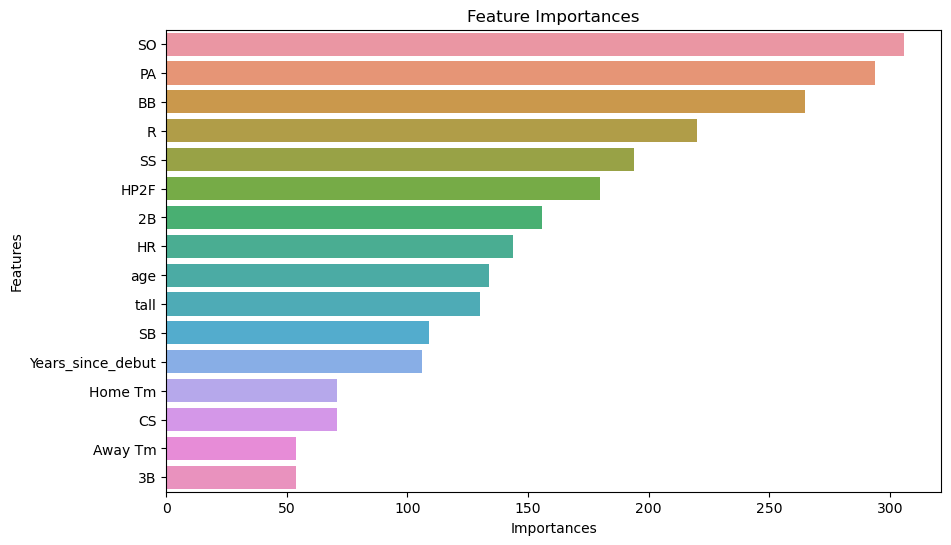

In [35]:
features = ['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']
# features = ['age','Years_since_debut','tall','Home Tm','Away Tm','Rank','SS','HP2F','PA','R','2B','3B','HR','RBI','BB','SO','SB','CS']
# features = ['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','PA','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']
feature_importances = model.feature_importances_
importances_df = pd.DataFrame({'Features': features, 'Importances': feature_importances})
importances_df = importances_df.sort_values(by='Importances', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Features', data=importances_df)
plt.title('Feature Importances')
plt.show()

# 2023年の最終成績の予測(アメリカンリーグ、LightGBM)
作ったモデルを使って、2023年の70試合経過時点での成績から年度末のヒット数を予測し、降順で表示します。

In [36]:
data_2023 = american_yearly_totals_df_first_70[american_yearly_totals_df_first_70['Year'] == 2023]
X_2023 = data_2023[['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']]
# X_2023 = data_2023[['age','Years_since_debut','tall','Home Tm','Away Tm','Rank','SS','HP2F','PA','R','2B','3B','HR','RBI','BB','SO','SB','CS']]
# X_2023 = data_2023[['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']]
predicted_hits = model.predict(X_2023)
hits_predictions_2023 = data_2023[['Year', 'Name']].copy()
hits_predictions_2023['Predicted_Hits'] = predicted_hits
hits_predictions_2023 = hits_predictions_2023.sort_values(by='Predicted_Hits', ascending=False)
hits_predictions_2023 = hits_predictions_2023.reset_index(drop=True)
top_10_hits_2023_first_70 = data_2023.sort_values(by='H', ascending=False)
top_10_hits_2023_first_70['First_70_Games_Rank'] = top_10_hits_2023_first_70['H'].rank(method='min', ascending=False)
hits_predictions_2023 = hits_predictions_2023.merge(top_10_hits_2023_first_70[['Name', 'First_70_Games_Rank']], on='Name', how='left')
hits_predictions_2023.rename(columns={'H': 'Actual_Hits_First_70'}, inplace=True)
hits_predictions_2023.head(20)


,Year,Name,Predicted_Hits,First_70_Games_Rank
0,2023,Alex Verdugo,184.034148,2.0
1,2023,Marcus Semien,175.067535,3.0
2,2023,Wander Franco,175.057342,4.0
3,2023,Luis Robert Jr.,172.934232,23.0
4,2023,Bobby Witt Jr.,171.006270,21.0
5,2023,Jose Ramirez,167.607837,7.0
6,2023,Esteury Ruiz,163.865498,17.0
7,2023,Ty France,162.239831,12.0
8,2023,Bo Bichette,161.350295,1.0
9,2023,Nathaniel Lowe,153.830056,11.0


# 2022年の予測と実際の成績(ナショナルリーグ、LightGBM)
2011~2021年(2020年度を除く)の各年度70試合経過時点でのデータを使って学習し、2022年度末のヒット数を選手ごとに予測します。

In [37]:
train_data = national_yearly_totals_df[national_yearly_totals_df['Year'] < 2023]
train_data_first_70 = national_yearly_totals_df_first_70[national_yearly_totals_df_first_70['Year'] < 2023]

test_data = national_yearly_totals_df[national_yearly_totals_df['Year'] == 2022]
test_data_first_70 = national_yearly_totals_df_first_70[national_yearly_totals_df_first_70['Year'] == 2022]

train_data = pd.merge(train_data[['Year', 'Name','H']], train_data_first_70, on=['Year', 'Name'])
test_data = pd.merge(test_data[['Year', 'Name','H']], test_data_first_70, on=['Year', 'Name'])


X_train = train_data_first_70[['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']]
# X_train = train_data_first_70[['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']]
y_train = train_data['H_x'].values
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

X_test = test_data_first_70[['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']]
# X_test = test_data_first_70[['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']]
y_test = test_data['H_x'].values
y_pred = model.predict(X_test)

results_2022 = test_data[['Year', 'Name']].copy()
results_2022['Predicted_Hits'] = y_pred
results_2022['Actual_Hits'] = y_test
results_2022['Rank'] = results_2022['Actual_Hits'].rank(method='min', ascending=False)
results_2022['Rank'] = results_2022['Rank'].astype(int)
results_2022 = results_2022.sort_values(by='Predicted_Hits', ascending=False)
results_2022 = results_2022.reset_index(drop=True)
results_2022.head(20)

,Year,Name,Predicted_Hits,Actual_Hits,Rank
0,2022,Freddie Freeman,191.473816,199,1
1,2022,Trea Turner,183.640167,194,2
2,2022,Paul Goldschmidt,179.394807,178,3
3,2022,Manny Machado,175.131726,172,6
4,2022,Dansby Swanson,173.618341,177,4
5,2022,Jeff McNeil,172.239917,174,5
6,2022,Nolan Arenado,165.395544,163,10
7,2022,Alec Bohm,164.248221,164,9
8,2022,Pete Alonso,162.323393,162,11
9,2022,Austin Riley,159.232645,168,8


# モデルの評価(ナショナルリーグ、LightGBM)
2022年のデータを用います。

In [38]:
mse = mean_squared_error(y_test[:5], y_pred[:5])
print(f"The Mean Squared Error of the predictions is {mse}")

rmse = mean_squared_error(y_test[:5], y_pred[:5], squared=False)
print(f"The Root Mean Squared Error of the predictions is {rmse}")

mae = mean_absolute_error(y_test[:5], y_pred[:5])
print(f"The Mean Absolute Error of the predictions is {mae}")

r2 = r2_score(y_test[:5], y_pred[:5])
print(f"The R^2 Score of the predictions is {r2}")

The Mean Squared Error of the predictions is 36.08971969449179
The Root Mean Squared Error of the predictions is 6.007471988656443
The Mean Absolute Error of the predictions is 4.884513493582597
The R^2 Score of the predictions is 0.645623333714731


# 特徴量重要度(ナショナルリーグ、LightGBM)
モデルで使用されている各特徴の重要度を示す棒グラフが作成されます。重要度の値が高いほど、その特徴が予測を行う上でより重要であることを意味します。

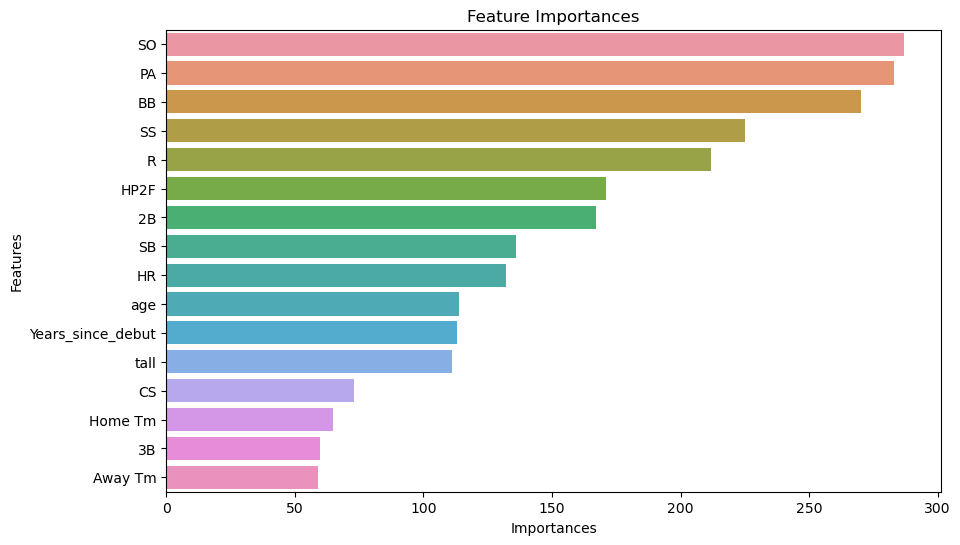

In [39]:
features = ['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']
# features = ['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']
feature_importances = model.feature_importances_
importances_df = pd.DataFrame({'Features': features, 'Importances': feature_importances})
importances_df = importances_df.sort_values(by='Importances', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Features', data=importances_df)
plt.title('Feature Importances')
plt.show()

# 2023年の最終成績の予測(ナショナルリーグ、LightGBM)
作ったモデルを使って、2023年の70試合経過時点での成績から年度末のヒット数を予測し、降順で表示します。

In [40]:
data_2023 = national_yearly_totals_df_first_70[national_yearly_totals_df_first_70['Year'] == 2023]
X_2023 = data_2023[['age','Years_since_debut','tall','Home Tm','Away Tm','SS','HP2F','PA','R','2B','3B','HR','BB','SO','SB','CS']]
# X_2023 = data_2023[['age','Years_since_debut','tall','bt','Home Tm','Away Tm','Rank','SS','HP2F','PA','AB','R','2B','3B','HR','RBI','BB','SO','SB','CS','HBP','AVG','OBP','SLG','OPS']]
predicted_hits = model.predict(X_2023)
hits_predictions_2023 = data_2023[['Year', 'Name']].copy()
hits_predictions_2023['Predicted_Hits'] = predicted_hits
hits_predictions_2023 = hits_predictions_2023.sort_values(by='Predicted_Hits', ascending=False)
hits_predictions_2023 = hits_predictions_2023.reset_index(drop=True)
top_10_hits_2023_first_70 = data_2023.sort_values(by='H', ascending=False)
top_10_hits_2023_first_70['First_70_Games_Rank'] = top_10_hits_2023_first_70['H'].rank(method='min', ascending=False)
hits_predictions_2023 = hits_predictions_2023.merge(top_10_hits_2023_first_70[['Name', 'First_70_Games_Rank']], on='Name', how='left')
hits_predictions_2023.rename(columns={'H': 'Actual_Hits_First_70'}, inplace=True)
hits_predictions_2023.head(30)

,Year,Name,Predicted_Hits,First_70_Games_Rank
0,2023,Freddie Freeman,179.945659,3.0
1,2023,Mookie Betts,178.101386,17.0
2,2023,Christian Walker,176.496343,17.0
3,2023,Ronald Acuna Jr.,176.021706,2.0
4,2023,Jonathan India,165.188536,14.0
5,2023,Joey Meneses,161.215618,6.0
6,2023,Ketel Marte,160.281447,9.0
7,2023,Ke'Bryan Hayes,155.468137,25.0
8,2023,Trea Turner,150.703127,14.0
9,2023,Lane Thomas,149.487781,7.0


In [41]:
hits_predictions_2023.head(50)

,Year,Name,Predicted_Hits,First_70_Games_Rank
0,2023,Freddie Freeman,179.945659,3.0
1,2023,Mookie Betts,178.101386,17.0
2,2023,Christian Walker,176.496343,17.0
3,2023,Ronald Acuna Jr.,176.021706,2.0
4,2023,Jonathan India,165.188536,14.0
5,2023,Joey Meneses,161.215618,6.0
6,2023,Ketel Marte,160.281447,9.0
7,2023,Ke'Bryan Hayes,155.468137,25.0
8,2023,Trea Turner,150.703127,14.0
9,2023,Lane Thomas,149.487781,7.0
